In [ ]:
!git clone https://github.com/Im-JihyunKim/2024_LG_ES_SSL.git  # colab 사용 시

In [ ]:
# Colab 사용 시 실행
# Local PC로 실습하는 경우에는 실행 X, 단 작업경로를 2024_LG_ES_RNN으로 맞춰주기
%cd /content/2024_LG_ES_SSL

In [1]:
# !pip install IPython
from IPython.display import Image

------

## Task: Self-supervised Learning - Pretext Task
### AutoEncoder

#### Jupyter Notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

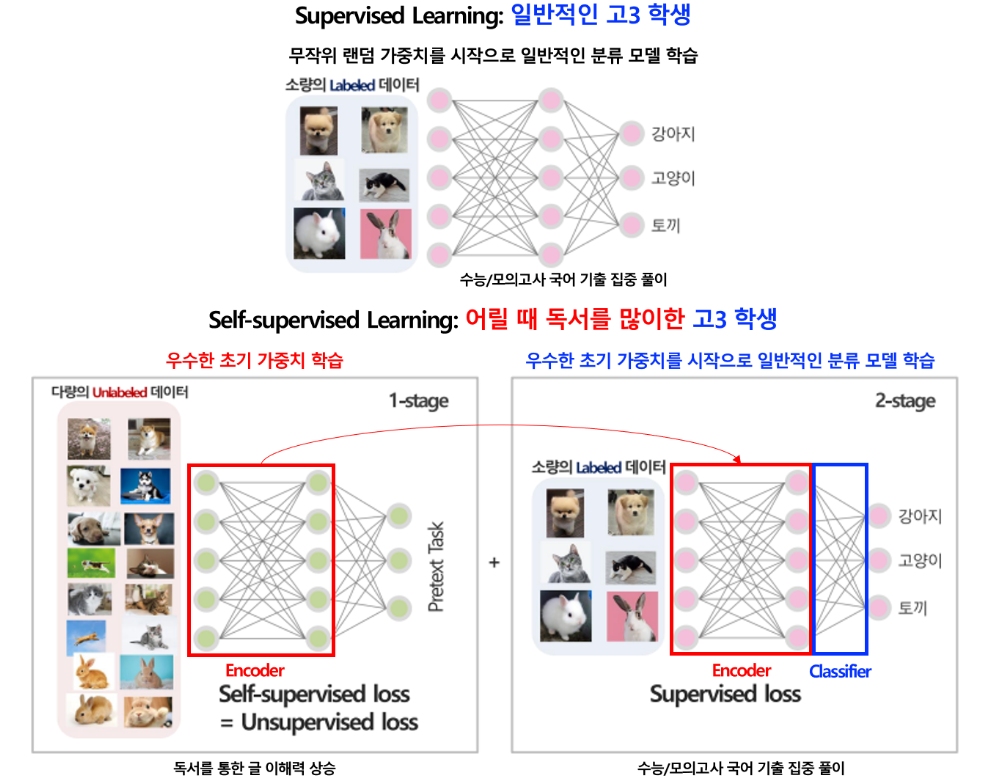

In [2]:
Image('images/2-SelfsupervisedLearning1.PNG')

## AutoEncoder
- Pretraining Task
- Downstream Task
- 실험 결과 비교

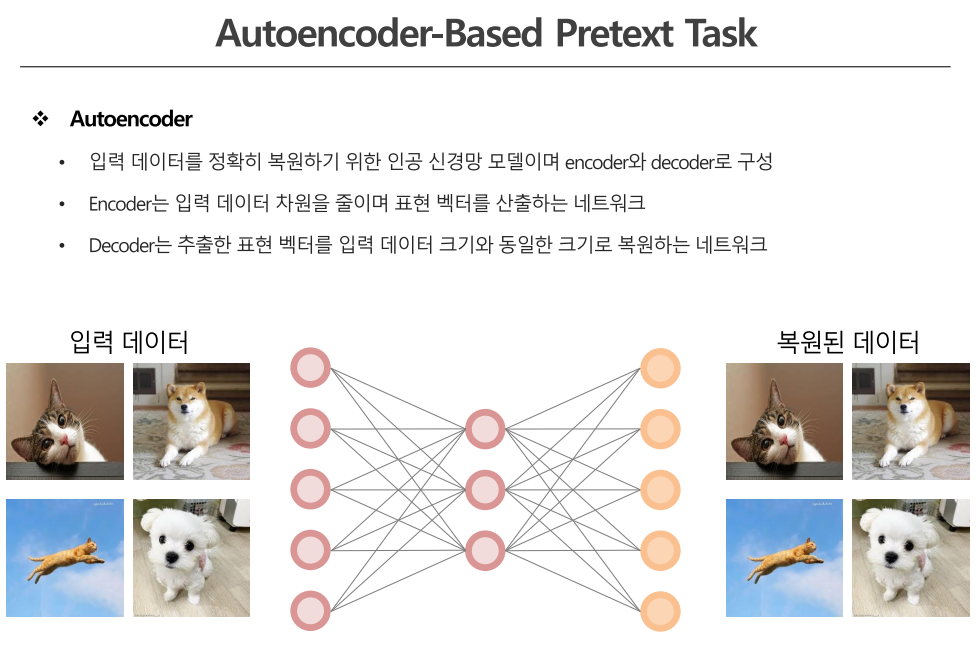

In [3]:
Image('images/5-AutoEncoder.PNG')

## 1. 필요 모듈(라이브러리) 호출

In [4]:
import os, random
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset  # 미니배치 학습, 데이터 셔플, 병렬 처리까지 간단하게 수행 가능하도록 지원
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.set_cmap('cividis')

import warnings
warnings.filterwarnings(action='ignore')

<Figure size 640x480 with 0 Axes>

## 2. 학습 전 준비

### GPU 확인 및 사용할 device 설정

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seed/Random state 고정

In [6]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

In [12]:
set_seed()  # 0으로 자동 설정
# set_seed(seed=0)

## 3. Custom Dataset 정의
- 방대한 데이터를 batch 단위로 쪼개서 불러올 수 있도록 정의해주는 과정 (기존에는 모든 데이터셋을 한꺼번에 처리)
- Custom Dataset은 가변 길이 input이나 batch를 만들어줄 때 필요  
cf. https://didu-story.tistory.com/85

### Fashion MNIST Dataset

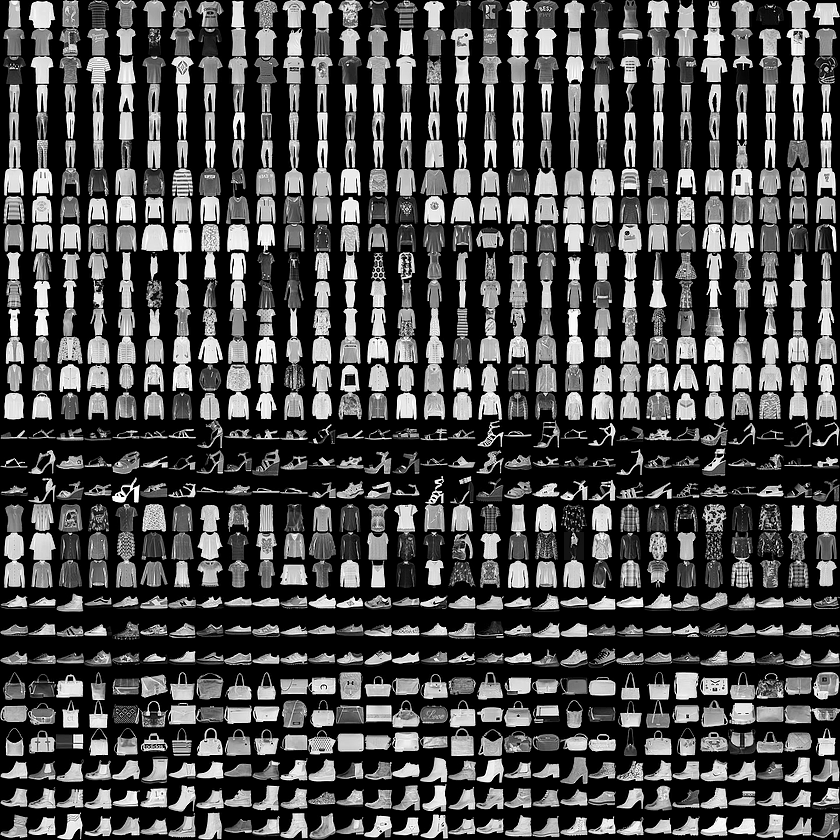

In [10]:
Image('images/3-FashionMNIST1.PNG')

- 28x28의 흑백 이미지로 구성된 데이터셋
  - 총 70,000개의 데이터가 있으며 일반적으로 60,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 60,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 따로 지정하지 않음)
- 10개의 class를 분류하는 image classification task

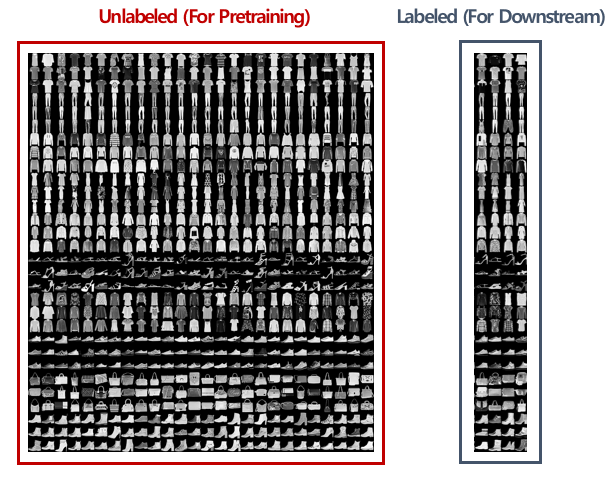

In [11]:
Image('images/3-FashionMNIST2.PNG')

In [13]:
# Custom Dataset
class FashionMNISTDataset(Dataset):
    
    ### 데이터셋 경로 정의
    def __init__(self, data_dir:str):
        self.data_dir = data_dir
        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(data_dir, exist_ok=True)

    ### Pretraining Task Dataset 불러오기
    def get_pretrain_dataset(self):
        pretrain_dataset = datasets.FashionMNIST(self.data_dir,
                                            train=True, ### True: 60,000개 데이터 불러오기 / False: 10,000개 데이터 불러오기
                                            transform=transforms.ToTensor(), ### jpg --> torch.tensor 변경
                                            download=True)
        return pretrain_dataset
    
    ### Downstream Task Dataset 불러오기
    def get_dataset(self, mode:str='train'):
        downstream_dataset = datasets.FashionMNIST(self.data_dir,
                                             train=False, ### True: 60,000개 데이터 불러오기 / False: 10,000개 데이터 불러오기
                                             transform=transforms.ToTensor(), ### jpg --> torch.tensor 변경
                                             download=True)
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), test_size=0.2, random_state=0)

        if mode == 'train': ### 학습용 데이터 선별: 10,000개 중 8,000개
            train_dataset = Subset(downstream_dataset, train_idx)  
            return train_dataset
        
        elif mode == 'test': ### 평가용 데이터 선별: 10,000개 중 8,000개
            test_dataset = Subset(downstream_dataset, test_idx)   
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")

### cf. Fashion MNIST 이미지

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\raw



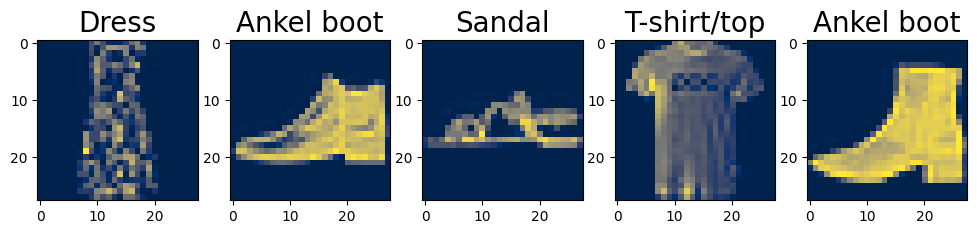

In [14]:
data_dir = './data/'

dataset = FashionMNISTDataset(data_dir)
data = dataset.get_pretrain_dataset()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']  # 총 10개의 classes

train_loader = DataLoader(
        dataset=data,
        batch_size=5,
        shuffle=True)
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12,3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## 3. AutoEncoder 네트워크 정의

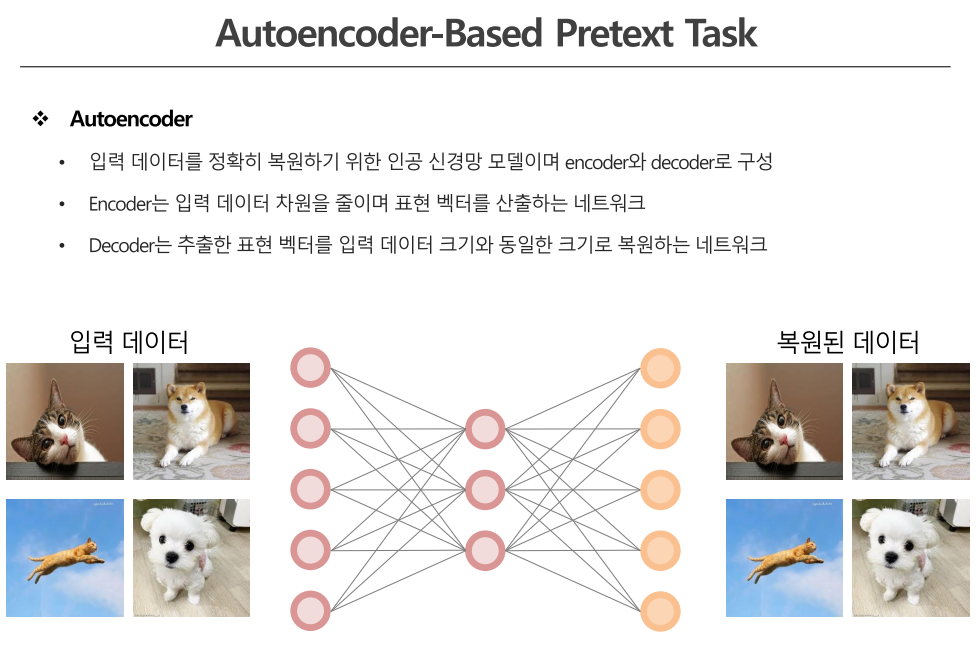

In [16]:
Image('images/5-AutoEncoder.PNG')

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder 정의
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축
        )

        # decoder 정의
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # 원본 이미지 크기로 복원
            nn.Sigmoid(),          # 픽셀당 0과 1 사이로 값을 출력
        )

    def forward(self, x):
        en_out = self.encoder(x)
        de_out = self.decoder(en_out)
        return de_out

## 4. AutoEncoder 사전학습 (Pretraining) 정의

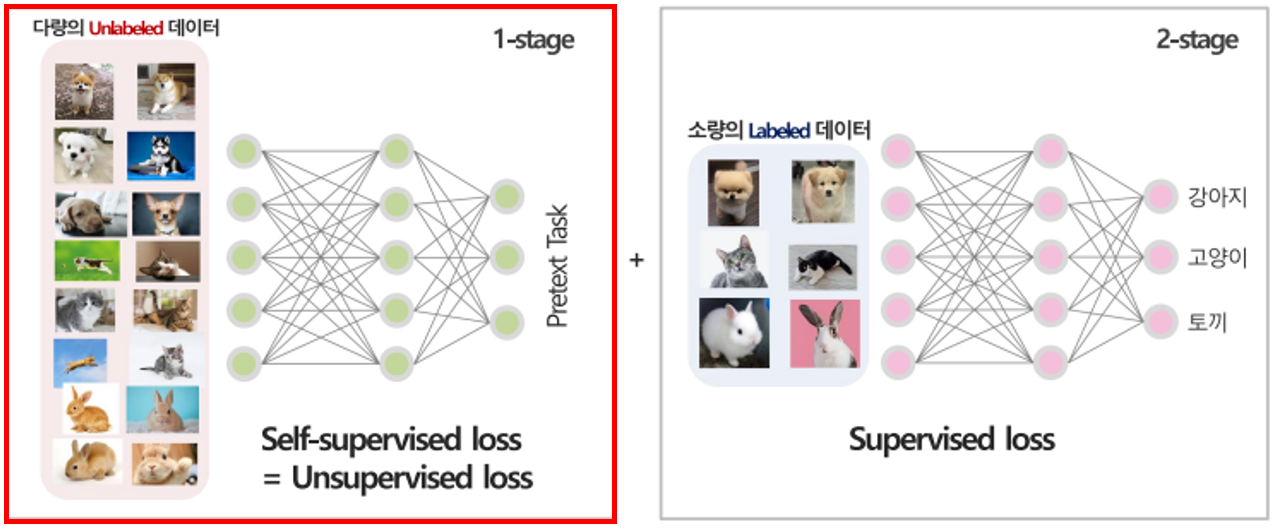

In [18]:
Image('images/2-SelfsupervisedLearning2.PNG')

In [19]:
class AE_Trainer(object):
    def __init__(self, device, model, **kwargs):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.MSELoss()  # loss - 재구축 오차
        self.__dict__.update(kwargs)

    def pretrain(self, train_loader):
        os.makedirs(self.ckpt_dir, exist_ok=True)  # create checkpoints directory

        for epoch in range(self.epochs+1):
            running_loss, running_total = 0.0, 0
            for images, _ in train_loader:

                # images 데이터 정의 (차원을 맞춰준 후 정의한 device 상으로 데이터 올리기)
                images = images.view(-1, 28*28).to(self.device)

                # outputs: 복원된 이미지 (encode-decode)
                outputs = self.model(images)

                # 모델 학습: 복원한 이미지와 실제 이미지의 squared loss (MSE)
                loss = self.criterion(outputs, images)

                """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
                loss.backward()  # Pytorch 자동 미분
                self.optimizer.step() # optimizer를 이용한 파라미터 업데이
                self.optimizer.zero_grad() # Optimizer Gradient 초기화

                # iteration 단위 (batch) loss 산출
                running_loss += loss.item() * images.size(0)
                running_total += images.size(0)

            epoch_loss = running_loss / running_total
            
            # logging
            if epoch == 0 or (epoch + 1) % 5 == 0:
                print('Epoch: {} Loss: {:.4f}'.format(epoch+1, epoch_loss))
        
        # Save the model (마지막 epoch에서 모델 저장)
        torch.save(self.model.encoder.state_dict(), os.path.join(self.ckpt_dir, 'pretrained_ae_model.pt'))

        return self.model

## 5. Pretraining Task 수행

In [20]:
""" 2. Pretraining Task 학습 수행 """
def main(device, configs:dict):

    # define dataset, dataloader
    dataset = FashionMNISTDataset(data_dir=configs['data_dir']) 
    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)
    
    # define model
    model = Autoencoder()

    # define optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Pretraining Task 학습 알고리즘 정의
    trainer = AE_Trainer(device=device, 
                        model=model, 
                        optimizer=optimizer,
                        batch_size = configs['batch_size'],
                        epochs = configs['epochs'],
                        ckpt_dir = configs['ckpt_dir']
                        )
    
    ### Pretraining Task 학습 수행
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    
    # configurations
    configs = {'data_dir': './data/',              
               'ckpt_dir': './results/AutoEncoder/',
               'batch_size': 256, 'epochs': 40, 
               'learning_rate': 5e-3, 'weight_decay':0, 'num_worker': 0}
    
    pretrained_model_ae = main(device, configs)

Epoch: 1 Loss: 0.0503
Epoch: 5 Loss: 0.0254
Epoch: 10 Loss: 0.0233
Epoch: 15 Loss: 0.0225
Epoch: 20 Loss: 0.0220
Epoch: 25 Loss: 0.0217
Epoch: 30 Loss: 0.0215
Epoch: 35 Loss: 0.0212
Epoch: 40 Loss: 0.0211


### 재구축이 잘 되었는지 확인

__1. Testset 원본 이미지__

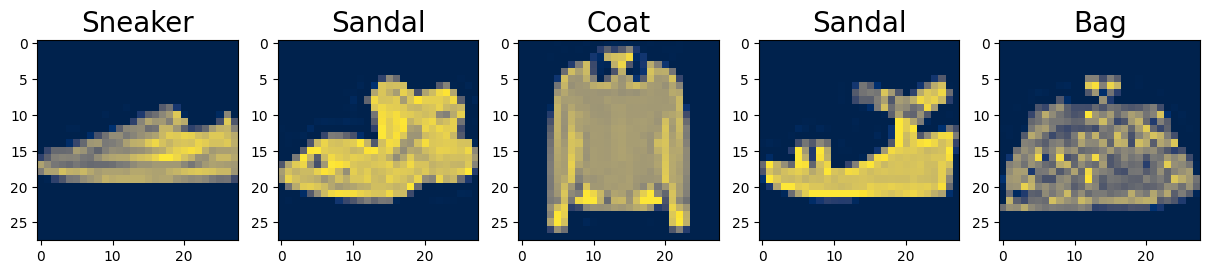

In [21]:
data_dir = configs['data_dir']

dataset = FashionMNISTDataset(data_dir)
data = dataset.get_dataset(mode='test')
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']  # 총 10개의 classes

test_loader = DataLoader(
        dataset=data,
        batch_size=5,
        shuffle=False)
images, labels = next(iter(test_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

__2. 복원된 Testset 이미지__

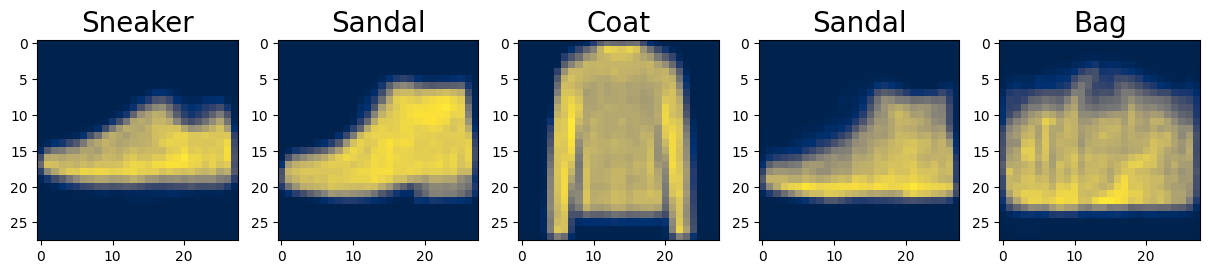

In [22]:
test_output = pretrained_model_ae(images.view(-1, 28*28).to('cuda:0')).cpu()

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), test_output, labels):
    numpy_img = img.detach().numpy().reshape(28, 28, -1)
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

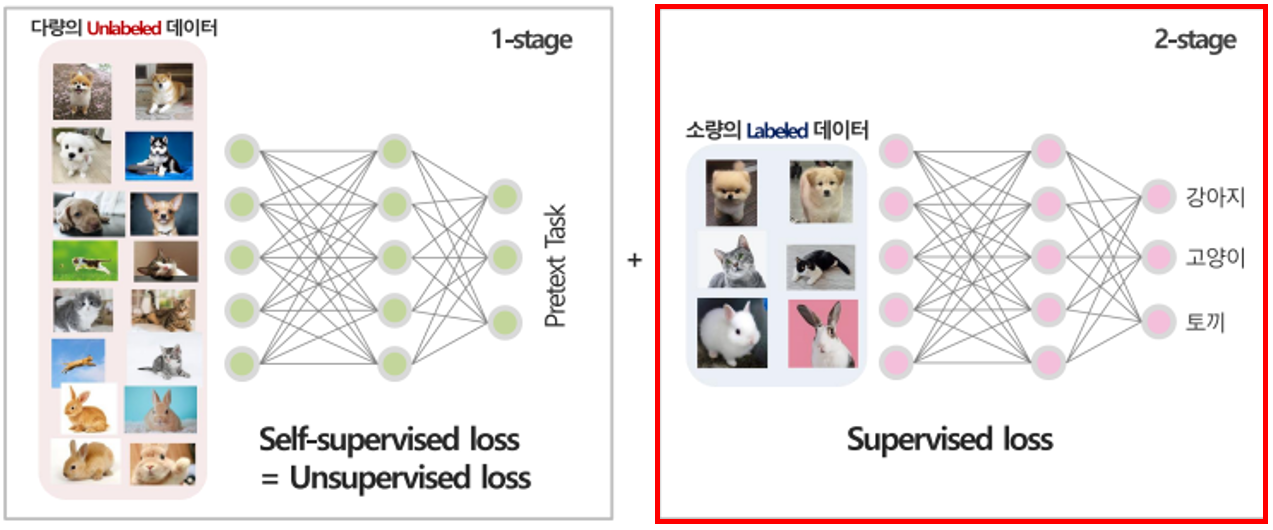

In [23]:
Image('images/2-SelfsupervisedLearning3.PNG')

In [65]:
""" 1. 평가지표 정의 - accuracy """

"""
Computes the accuracy over the top k predictions for the specified values of k
Top1 Accuracy: 모델의 Top1 예측 결과가 실제 Label과 동일 --> Correct
Top5 Accuracy: 모델의 Top5 예측 결과 내에 실제 Label의 포함 --> Correct
"""

def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    
    ### max_k기준 correct 여부 판별
    with torch.no_grad():
        max_k = max(topk)
        batch_size = target.size(0) 
        # output.topk()로 각 샘플에 대해 가장 높은 확률을 가진 max_k개의 클래스 인덱스 구하기
        _, pred = output.topk(k=max_k, dim=1, largest=True, sorted=True)
        pred = pred.t()  # transpose
        # 예측이 정답과 일치하는지 비교
        correct = pred.eq(target.view(1, -1).expand_as(pred)) ### eq: 동일여부 판별
        # target -> one-hot encoding 없이 true class idx가 있음

        ### 확인하고 싶은 topk 지표들을 모두 산출 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

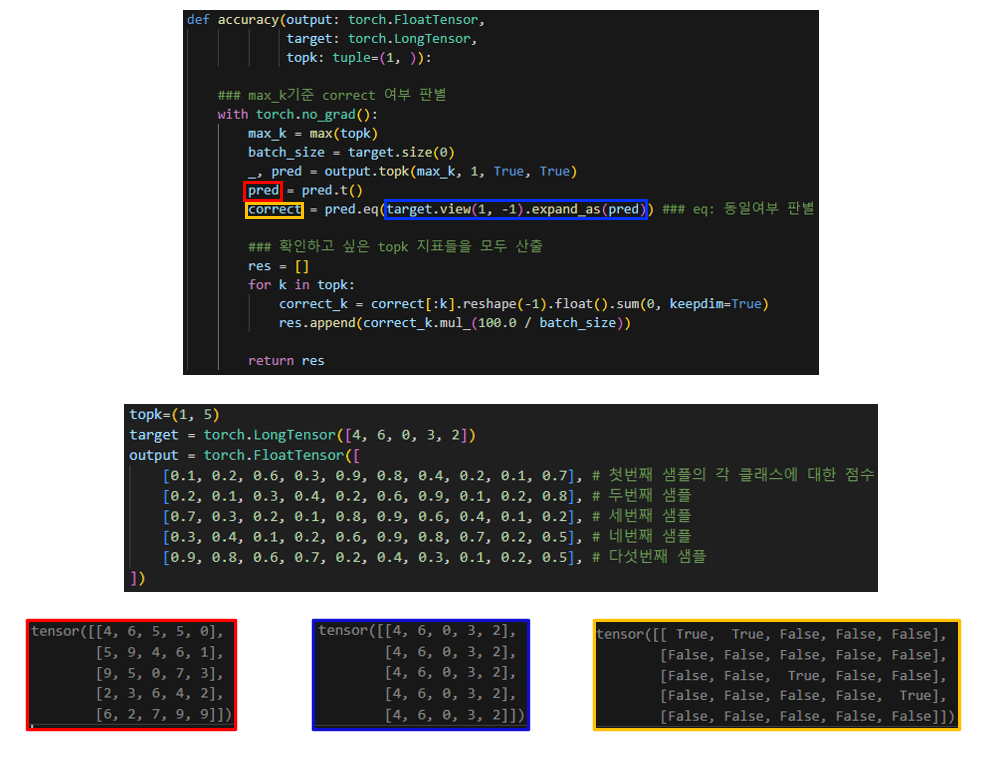

In [24]:
Image('images/14-Metric1.PNG')

In [78]:
""" 2. 미세조정 (Downstream Task) 학습 알고리즘 정의 """
class Downstream(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device
        self.encoder = encoder.to(device)
        self.classifier = classifier.to(device)
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    ### Downstream Task 학습 알고리즘
    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):

            ### train 모드
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.view(-1, 28*28).to(self.device)
                targets = targets.to(self.device)
                
                ### 사전학습된 Encoder에 데이터 통과
                if self.downstream: ### Encoder Weight(사전학습된)를 학습하지 않음
                    with torch.no_grad():
                        features = self.encoder(images)
                        features = features.view(features.size(0), -1)  # flattten
                else: ### Encoder Weight를 함께 학습
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)      # flattten

                ### Classifier에 통과
                logits = self.classifier(features)
                loss = self.criterion(logits, targets)

                ### 모델 학습
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                ### Iteration 단위(Batch) 평가 지표 산출
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss
            
            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            ### Test 모드 -> 성능 logging을 위함!
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.view(-1, 28*28).to(self.device)
                targets = targets.to(self.device)

                ### 데이터를 모델(Encoder + Classifier)에 통과 
                with torch.no_grad():
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)  
                    logits = self.classifier(features)

                ### Iteration 단위(Batch) 평가 지표 산출
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            ### Log
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {round(train_loss.item(), 4)} \n'
                  f'Top1 Train Accuracy: {round(top1_train_acc.item(), 2)} \n'
                  f'Top1 Test Accuracy: {round(top1_test_acc.item(), 2)} \n'
                  f'Top5 Test Accuracy: {round(top5_test_acc.item(), 2)} \n')
        
        return self.encoder, self.classifier

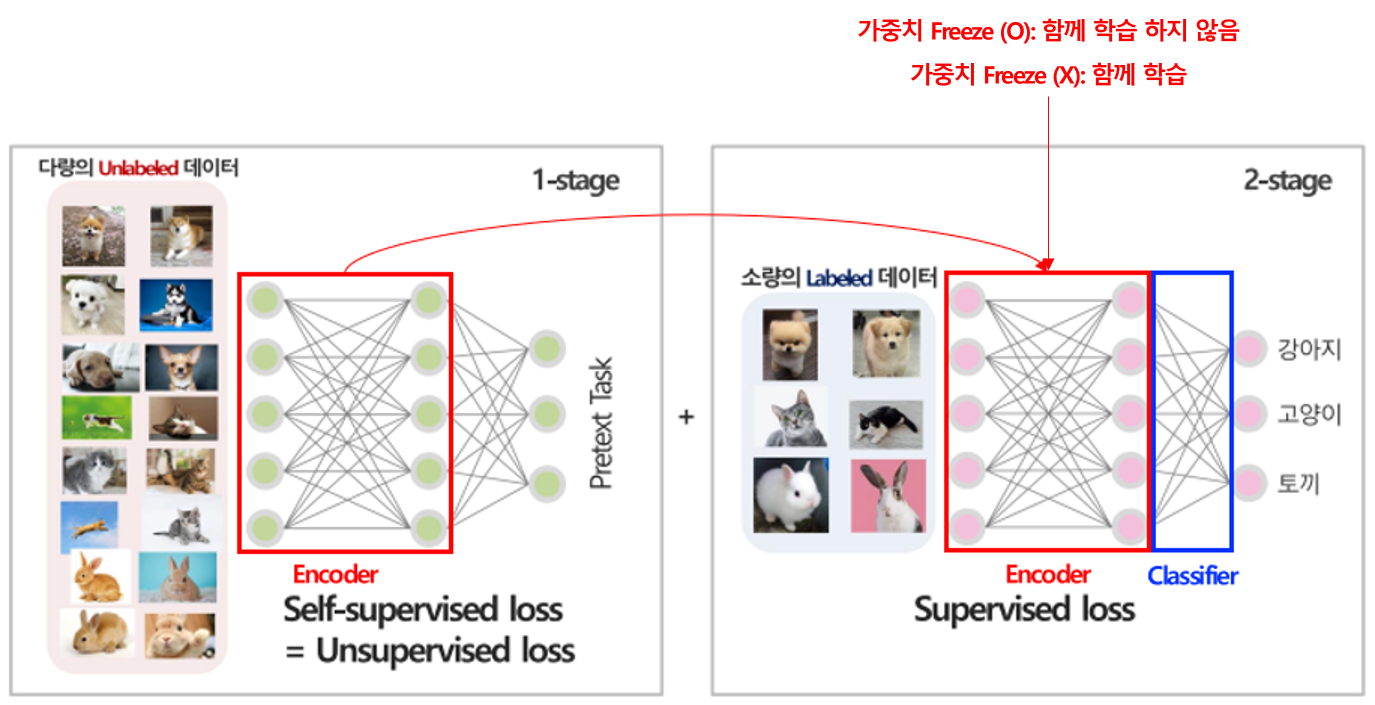

In [79]:
Image('images/2-SelfsupervisedLearning4.PNG')

In [80]:
""" 3. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])   
    
    train_dataset = dataset.get_dataset(mode='train')  # downstream용 데이터셋 불러오기
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    # 사전학습된 encoder의 파라미터를 불러오는 과정
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'], 'pretrained_ae_model.pt')))
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 

    configs = {'data_dir': './data/', 
               'ckpt_dir': './results/AutoEncoder/', 
               'downstream': True, 'batch_size': 256, 'epochs': 10,
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    
    supervised_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 2.5278 
Top1 Train Accuracy: 9.34 
Top1 Test Accuracy: 17.6 
Top5 Test Accuracy: 60.87 

Epoch: 2 
Loss: 2.0697 
Top1 Train Accuracy: 24.17 
Top1 Test Accuracy: 31.26 
Top5 Test Accuracy: 90.82 

Epoch: 3 
Loss: 1.792 
Top1 Train Accuracy: 41.39 
Top1 Test Accuracy: 47.25 
Top5 Test Accuracy: 96.69 

Epoch: 4 
Loss: 1.6093 
Top1 Train Accuracy: 51.67 
Top1 Test Accuracy: 55.56 
Top5 Test Accuracy: 97.63 

Epoch: 5 
Loss: 1.4669 
Top1 Train Accuracy: 56.08 
Top1 Test Accuracy: 58.05 
Top5 Test Accuracy: 98.28 

Epoch: 6 
Loss: 1.3411 
Top1 Train Accuracy: 57.82 
Top1 Test Accuracy: 59.67 
Top5 Test Accuracy: 98.52 

Epoch: 7 
Loss: 1.2422 
Top1 Train Accuracy: 60.1 
Top1 Test Accuracy: 62.23 
Top5 Test Accuracy: 98.51 

Epoch: 8 
Loss: 1.1565 
Top1 Train Accuracy: 62.6 
Top1 Test Accuracy: 64.29 
Top5 Test Accuracy: 98.51 

Epoch: 9 
Loss: 1.0938 
Top1 Train Accuracy: 64.27 
Top1 Test Accuracy: 65.45 
Top5 Test Accuracy: 98.82 

Epoch: 10 
L

##### Freeze 후 downstream: (Top 1) 66.24 / (Top 5) 98.76

In [81]:
""" 3. 미세조정 (Downstream Task) 수행 - Encoder Freeze (X) """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir'])   
    
    train_dataset = dataset.get_dataset(mode='train')  # downstream용 데이터셋 불러오기
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'], 'pretrained_ae_model.pt'))) ### 사전학습된 Weight 불러오기
    print("All keys matched successfully")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Pretraining Task 학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 

    configs = {'data_dir': './data/', 
               'ckpt_dir': './results/AutoEncoder/', 
               'downstream': False, 'batch_size': 256, 'epochs': 10,
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

All keys matched successfully
Epoch: 1 
Loss: 2.3378 
Top1 Train Accuracy: 12.82 
Top1 Test Accuracy: 13.48 
Top5 Test Accuracy: 63.43 

Epoch: 2 
Loss: 1.9982 
Top1 Train Accuracy: 27.55 
Top1 Test Accuracy: 38.84 
Top5 Test Accuracy: 89.09 

Epoch: 3 
Loss: 1.7808 
Top1 Train Accuracy: 45.13 
Top1 Test Accuracy: 54.01 
Top5 Test Accuracy: 95.42 

Epoch: 4 
Loss: 1.6089 
Top1 Train Accuracy: 56.26 
Top1 Test Accuracy: 60.3 
Top5 Test Accuracy: 98.05 

Epoch: 5 
Loss: 1.461 
Top1 Train Accuracy: 60.74 
Top1 Test Accuracy: 62.73 
Top5 Test Accuracy: 98.23 

Epoch: 6 
Loss: 1.3408 
Top1 Train Accuracy: 62.46 
Top1 Test Accuracy: 62.99 
Top5 Test Accuracy: 98.46 

Epoch: 7 
Loss: 1.2435 
Top1 Train Accuracy: 63.53 
Top1 Test Accuracy: 64.95 
Top5 Test Accuracy: 98.57 

Epoch: 8 
Loss: 1.1657 
Top1 Train Accuracy: 64.16 
Top1 Test Accuracy: 65.88 
Top5 Test Accuracy: 98.72 

Epoch: 9 
Loss: 1.0972 
Top1 Train Accuracy: 65.31 
Top1 Test Accuracy: 65.75 
Top5 Test Accuracy: 98.72 

Epoch: 10

##### Freeze 없이 모두 재학습: (Top 1) 67.00 / (Top 5) 98.67

### Supervised Learning

In [82]:
""" 1. 비교군(지도학습) 모델 학습 """
def main(device, configs: dict):
    
    ### Train 및 Test 데이터셋 정의
    dataset = FashionMNISTDataset(data_dir=configs['data_dir']) 
    
    train_dataset = dataset.get_dataset(mode='train')
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = Autoencoder().encoder   # encoder만 가져오기
    print("Supervised Learning")
    
    classifier = nn.Sequential(
        nn.Linear(3, 32),
        nn.ReLU(),
        nn.Linear(32, configs['num_class'])
    )

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### 지도학습 알고리즘 정의
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream=configs['downstream'])
    
    ### 지도학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',
               'downstream': False, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 1e-3, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Supervised Learning
Epoch: 1 
Loss: 2.3138 
Top1 Train Accuracy: 9.83 
Top1 Test Accuracy: 10.59 
Top5 Test Accuracy: 49.88 

Epoch: 2 
Loss: 2.3046 
Top1 Train Accuracy: 9.79 
Top1 Test Accuracy: 10.59 
Top5 Test Accuracy: 49.06 

Epoch: 3 
Loss: 2.3025 
Top1 Train Accuracy: 12.01 
Top1 Test Accuracy: 18.45 
Top5 Test Accuracy: 49.88 

Epoch: 4 
Loss: 2.3017 
Top1 Train Accuracy: 11.18 
Top1 Test Accuracy: 7.8 
Top5 Test Accuracy: 55.8 

Epoch: 5 
Loss: 2.3014 
Top1 Train Accuracy: 10.95 
Top1 Test Accuracy: 9.67 
Top5 Test Accuracy: 48.14 

Epoch: 6 
Loss: 2.3009 
Top1 Train Accuracy: 9.89 
Top1 Test Accuracy: 9.27 
Top5 Test Accuracy: 56.25 

Epoch: 7 
Loss: 2.3003 
Top1 Train Accuracy: 10.79 
Top1 Test Accuracy: 9.36 
Top5 Test Accuracy: 53.15 

Epoch: 8 
Loss: 2.2997 
Top1 Train Accuracy: 11.6 
Top1 Test Accuracy: 18.14 
Top5 Test Accuracy: 53.96 

Epoch: 9 
Loss: 2.2992 
Top1 Train Accuracy: 11.78 
Top1 Test Accuracy: 11.6 
Top5 Test Accuracy: 51.05 

Epoch: 10 
Loss: 2.2983 
Top

##### Supervised Learning: (Top 1) 18.04 / (Top 5) 61.32

##### Freeze 후 downstream: (Top 1) 66.24 / (Top 5) 98.76

### 성능 비교

|   | Supervised Learning | AutoEncoder (Freeze O) | AutoEncoder (Freeze X) |
|---| ------------------- | ---------------------- | ---------------------- |
|Top 1 Train ACC| 13.37 | 66.19 | 65.50 |
|Top 1 Test ACC| 18.04 | 67.00 | 66.24 |
|Top 5 Test ACC| 61.32 | 98.67 | 98.76 |